In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils 


from torchvision import transforms

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

## custom Batch Generator

### 1. load trn, val data

In [4]:
trn = pd.read_csv("./dnn_data/trn.tsv", sep='\t')
val = pd.read_csv("./dnn_data/val.tsv", sep='\t')

In [5]:
trn.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,y
0,0.770747,1.777481,1.119744,10,0.904246,0.750227,6,7,74.559605
1,0.517279,2.102868,1.433156,10,0.835582,0.982529,4,1,68.654484
2,0.528888,2.287112,1.181075,1,0.944968,0.961392,7,2,81.007162
3,0.398252,1.285644,0.968844,1,0.946535,0.748881,7,7,82.157630
4,0.483614,2.503184,1.563709,10,0.936454,0.945359,7,10,86.360000


In [7]:
X_features = ["feature_1", "feature_2", "feature_3", "feature_4", "feature_5", "feature_6", "feature_7", "feature_8"]
y_feature = ["y"]

In [8]:
trn_X_pd, trn_y_pd = trn[X_features], trn[y_feature]
val_X_pd, val_y_pd = val[X_features], val[y_feature]

In [16]:
trn_X = torch.from_numpy(trn_X_pd.astype(float).as_matrix())
trn_y = torch.from_numpy(trn_y_pd.astype(float).as_matrix())

val_X = torch.from_numpy(val_X_pd.astype(float).as_matrix())
val_y = torch.from_numpy(val_y_pd.astype(float).as_matrix())

In [3]:
batch_size=64

In [17]:
trn = data_utils.TensorDataset(trn_X, trn_y)
trn_loader = data_utils.DataLoader(trn, batch_size=batch_size, shuffle=True)

val = data_utils.TensorDataset(val_X, val_y)
val_loader = data_utils.DataLoader(val, batch_size=batch_size, shuffle=False)

In [29]:
tmp = next(iter(trn_loader))

In [30]:
tmp

{'X': tensor([[[ 0.0534,  0.2236,  0.0036,  0.0791,  0.0572,  0.0774,  0.5535,
            0.7907]],
 
         [[ 0.0690,  0.2621,  0.0414,  0.1100,  0.0772,  0.1084,  0.5499,
            0.7698]],
 
         [[ 0.0346,  0.1369,  0.0007,  0.5111,  0.0247,  0.0480,  0.3578,
            0.7667]],
 
         [[ 0.0512,  0.1661,  0.0400,  0.8614,  0.0597,  0.0858,  0.4307,
            0.1723]],
 
         [[ 0.0424,  0.1873,  0.2156,  0.8381,  0.0610,  0.0827,  0.4190,
            0.1676]],
 
         [[ 0.0345,  0.2083,  0.0795,  0.0772,  0.0503,  0.0772,  0.4629,
            0.8487]],
 
         [[ 0.0341,  0.1154,  0.0996,  0.6681,  0.0600,  0.0595,  0.4008,
            0.6012]],
 
         [[ 0.0241,  0.0971,  0.0581,  0.4561,  0.0354,  0.0351,  0.3193,
            0.8210]],
 
         [[ 0.1037,  0.3785,  0.0202,  0.1523,  0.1071,  0.1479,  0.7617,
            0.4570]],
 
         [[ 0.0506,  0.1621,  0.0102,  0.9036,  0.0904,  0.0867,  0.3615,
            0.0904]],
 
         [[ 0.0

In [32]:
num_batches = len(trn_loader)

## Build Model

In [33]:
use_cuda = torch.cuda.is_available()

In [34]:
class MLPRegressor(nn.Module):
    
    def __init__(self):
        super(MLPRegressor, self).__init__()
        h1 = nn.Linear(len(X_features), 50)
        h2 = nn.Linear(50, 35)
        h3 = nn.Linear(35, 1)
        self.hidden = nn.Sequential(
            h1,
            nn.Tanh(),
            h2,
            nn.Tanh(),
            h3,
        )
        if use_cuda:
            self.hidden = self.hidden.cuda()
        
    def forward(self, x):
        o = self.hidden(x)
        return o.view(-1)

## Train model

In [35]:
model = MLPRegressor()

In [36]:
criterion = nn.MSELoss()
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [37]:
num_epochs = 10
num_batches = len(trn_loader)

In [38]:
num_batches

35

In [39]:
trn_loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    trn_loss_summary = 0.0
    for i, trn in enumerate(trn_loader):
        trn_X, trn_y = trn['X'], trn['y']
        if use_cuda:
            trn_X, trn_y = trn_X.cuda(), trn_y.cuda()
        optimizer.zero_grad()
        trn_pred = model(trn_X)
        trn_loss = criterion(trn_pred, trn_y)
        trn_loss.backward()
        optimizer.step()
        
        trn_loss_summary += trn_loss
        
        if (i+1) % 15 == 0:
            with torch.no_grad():
                val_loss_summary = 0.0
                for j, val in enumerate(val_loader):
                    val_X, val_y = val['X'], val['y']
                    if use_cuda:
                        val_X, val_y = val_X.cuda(), val_y.cuda()
                    val_pred = model(val_X)
                    val_loss = criterion(val_pred, val_y)
                    val_loss_summary += val_loss
                
            print("epoch: {}/{} | step: {}/{} | trn_loss: {:.4f} | val_loss: {:.4f}".format(
                epoch + 1, num_epochs, i+1, num_batches, (trn_loss_summary/15)**(1/2), (val_loss_summary/len(val_loader))**(1/2)
            ))
                
            trn_loss_list.append((trn_loss_summary/15)**(1/2))
            val_loss_list.append((val_loss_summary/len(val_loader))**(1/2))
            trn_loss_summary = 0.0
        
print("finish Training")

epoch: 1/10 | step: 15/35 | trn_loss: 80.4772 | val_loss: 79.9006
epoch: 1/10 | step: 30/35 | trn_loss: 79.5698 | val_loss: 78.7983
epoch: 2/10 | step: 15/35 | trn_loss: 77.8362 | val_loss: 76.9738
epoch: 2/10 | step: 30/35 | trn_loss: 76.5909 | val_loss: 75.7759
epoch: 3/10 | step: 15/35 | trn_loss: 75.1105 | val_loss: 74.2213
epoch: 3/10 | step: 30/35 | trn_loss: 73.8596 | val_loss: 73.4308
epoch: 4/10 | step: 15/35 | trn_loss: 72.9306 | val_loss: 72.4381
epoch: 4/10 | step: 30/35 | trn_loss: 72.2745 | val_loss: 71.6900
epoch: 5/10 | step: 15/35 | trn_loss: 71.4342 | val_loss: 70.8200
epoch: 5/10 | step: 30/35 | trn_loss: 70.6700 | val_loss: 70.2096
epoch: 6/10 | step: 15/35 | trn_loss: 69.7620 | val_loss: 69.4448
epoch: 6/10 | step: 30/35 | trn_loss: 69.3763 | val_loss: 68.8077
epoch: 7/10 | step: 15/35 | trn_loss: 68.6557 | val_loss: 68.0679
epoch: 7/10 | step: 30/35 | trn_loss: 67.7106 | val_loss: 67.4442
epoch: 8/10 | step: 15/35 | trn_loss: 66.9765 | val_loss: 66.6800
epoch: 8/1

### Visualize

Text(0,0.5,'loss')

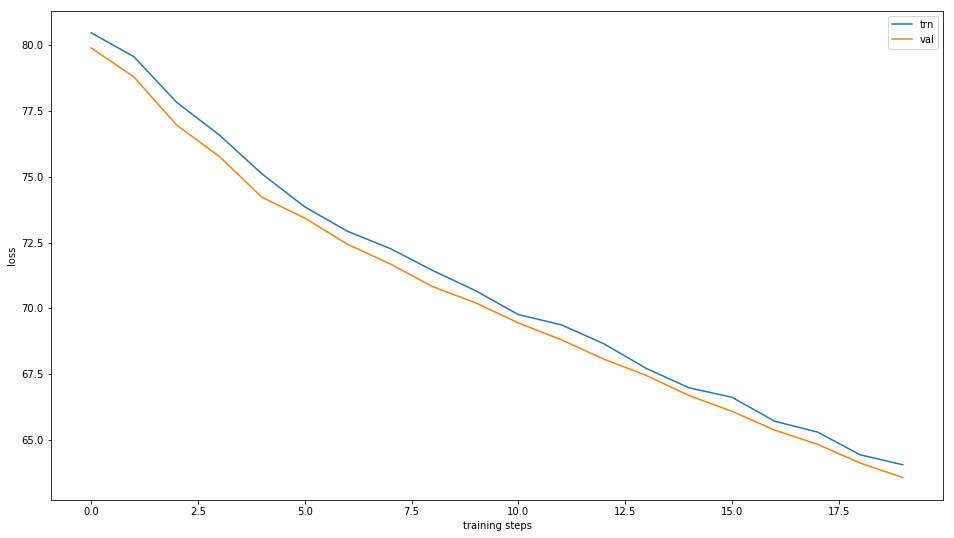

In [40]:
plt.figure(figsize=(16,9))
x_range = range(len(trn_loss_list))
plt.plot(x_range, trn_loss_list, label="trn")
plt.plot(x_range, val_loss_list, label="val")
plt.legend()
plt.xlabel("training steps")
plt.ylabel("loss")